# 8.6 Grammar Development

In [1]:
import nltk
from nltk.corpus import treebank
print(treebank.parsed_sents('wsj_0001.mrg')[0])

(S
  (NP-SBJ
    (NP (NNP Pierre) (NNP Vinken))
    (, ,)
    (ADJP (NP (CD 61) (NNS years)) (JJ old))
    (, ,))
  (VP
    (MD will)
    (VP
      (VB join)
      (NP (DT the) (NN board))
      (PP-CLR (IN as) (NP (DT a) (JJ nonexecutive) (NN director)))
      (NP-TMP (NNP Nov.) (CD 29))))
  (. .))


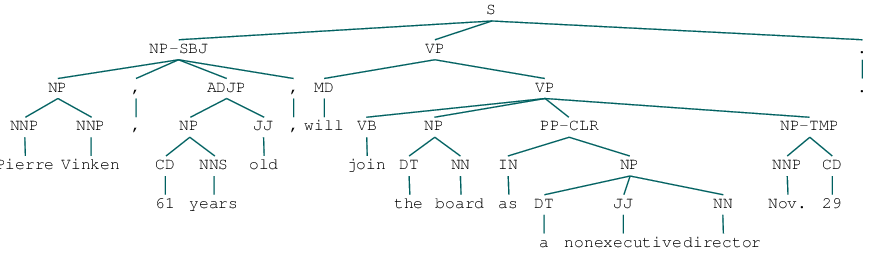

In [2]:
treebank.parsed_sents('wsj_0001.mrg')[0]

In [3]:
def filter(tree):
    child_nodes = [child.label() for child in tree if isinstance(child, nltk.Tree)]
    return (tree.label() == 'VP') and ('S' in child_nodes)

In [4]:
from nltk.corpus import treebank
[subtree for tree in treebank.parsed_sents() for subtree in tree.subtrees(filter)]

[Tree('VP', [Tree('VBN', ['named']), Tree('S', [Tree('NP-SBJ', [Tree('-NONE-', ['*-1'])]), Tree('NP-PRD', [Tree('NP', [Tree('DT', ['a']), Tree('JJ', ['nonexecutive']), Tree('NN', ['director'])]), Tree('PP', [Tree('IN', ['of']), Tree('NP', [Tree('DT', ['this']), Tree('JJ', ['British']), Tree('JJ', ['industrial']), Tree('NN', ['conglomerate'])])])])])]),
 Tree('VP', [Tree('VBD', ['said']), Tree(',', [',']), Tree('``', ['``']), Tree('S', [Tree('NP-SBJ', [Tree('DT', ['This'])]), Tree('VP', [Tree('VBZ', ['is']), Tree('NP-PRD', [Tree('DT', ['an']), Tree('JJ', ['old']), Tree('NN', ['story'])])])])]),
 Tree('VP', [Tree('VBD', ['said']), Tree('S', [Tree('-NONE-', ['*T*-1'])])]),
 Tree('VP', [Tree('VBN', ['expected']), Tree('S', [Tree('-NONE-', ['*?*'])])]),
 Tree('VP', [Tree('VBD', ['said']), Tree('S', [Tree('-NONE-', ['*T*-1'])])]),
 Tree('VP', [Tree('VBZ', ['appears']), Tree('S', [Tree('NP-SBJ', [Tree('-NONE-', ['*-1'])]), Tree('VP', [Tree('TO', ['to']), Tree('VP', [Tree('VB', ['be']), Tree('

### Projective Dependency Parser

In [5]:
from collections import defaultdict
entries = nltk.corpus.ppattach.attachments('training')
table = defaultdict(lambda: defaultdict(set))
for entry in entries:
    key = entry.noun1 + '-' + entry.prep + '-' + entry.noun2
    table[key][entry.attachment].add(entry.verb)

for key in sorted(table):
    if len(table[key]) > 1:
        print(key, 'N:' , sorted(table[key]['N']), 'V:', sorted(table[key]['V']))

%-below-level N: ['left'] V: ['be']
%-from-year N: ['was'] V: ['declined', 'dropped', 'fell', 'grew', 'increased', 'plunged', 'rose', 'was']
%-in-August N: ['was'] V: ['climbed', 'fell', 'leaping', 'rising', 'rose']
%-in-September N: ['increased'] V: ['climbed', 'declined', 'dropped', 'edged', 'fell', 'grew', 'plunged', 'rose', 'slipped']
%-in-week N: ['declined'] V: ['was']
%-to-% N: ['add', 'added', 'backed', 'be', 'cut', 'go', 'grow', 'increased', 'increasing', 'is', 'offer', 'plummet', 'reduce', 'rejected', 'rise', 'risen', 'shaved', 'wants', 'yield', 'zapping'] V: ['fell', 'rise', 'slipped']
%-to-million N: ['declining'] V: ['advanced', 'climbed', 'cutting', 'declined', 'declining', 'dived', 'dropped', 'edged', 'fell', 'gained', 'grew', 'increased', 'jump', 'jumped', 'plunged', 'rising', 'rose', 'slid', 'slipped', 'soared', 'tumbled']
1-to-21 N: ['dropped'] V: ['dropped']
1-to-33 N: ['gained'] V: ['dropped', 'fell', 'jumped']
1-to-4 N: ['added'] V: ['gained']
1-to-47 N: ['jumped']

We notice 
`offer-from-group N: ['rejected'] V: ['received']`, which indicates that `received` expects a separate $PP$ complement attached to the $VP$, while `rejected` does not. 

As sentences can be ambiguous, we need to use `probabilistic parsing` to help us *rank* the parses of an ambiguous sentence based on the evidence in the corpora.

In [7]:
def give(t):
    return t.label() == 'VP' and len(t) > 2 and t[1].label() == "NP"\
           and (t[2].label() == 'PP-DTV' or t[2].label() == 'NP')\
           and ('give' in t[0].leaves() or 'gave' in t[0].leaves())

def sent(t):
    return ' '.join(token for token in t.leaves() if token[0] not in '*-0')

def print_node(t, width):
    output = '%s %s: %s / %s: %s' % \
    (sent(t[0]), t[1].label(), sent(t[1]), t[2].label(), sent(t[2]))
    if len(output) > width:
        output = output[:width] + "..."
    print(output)

The verb `give` requires both a direct object ($DO$) and an indirect object ($IO$). They can be in either order e.g.:

- Kim gave a bone $(DO)$ to the dog $(IO)$ (prepositional dative form)
- Kim gave the dog ($IO$) a bone ($DO$) (double object form)

In [8]:
for tree in nltk.corpus.treebank.parsed_sents():
    for t in tree.subtrees(give):
        print_node(t, 72)

gave NP: the chefs / NP: a standing ovation
give NP: advertisers / NP: discounts for maintaining or increasing ad sp...
give NP: it / PP-DTV: to the politicians
gave NP: them / NP: similar help
give NP: them / NP: 
give NP: only French history questions / PP-DTV: to students in a Europe...
give NP: federal judges / NP: a raise
give NP: consumers / NP: the straight scoop on the U.S. waste crisis
gave NP: Mitsui / NP: access to a high-tech medical product
give NP: Mitsubishi / NP: a window on the U.S. glass industry
give NP: much thought / PP-DTV: to the rates she was receiving , nor to ...
give NP: your Foster Savings Institution / NP: the gift of hope and free...
give NP: market operators / NP: the authority to suspend trading in futu...
gave NP: quick approval / PP-DTV: to $ 3.18 billion in supplemental appr...
give NP: the Transportation Department / NP: up to 50 days to review any...
give NP: the president / NP: such power
give NP: me / NP: the heebie-jeebies
give NP: holders / NP: 

A **probabilistic context-free grammar** or **PCFG** is a context free grammar that associates a probability with each of its productions. 

In [16]:
grammar = nltk.PCFG.fromstring("""
    S    -> NP VP              [1.0]
    VP   -> TV NP              [0.4]
    VP   -> IV                 [0.3]
    VP   -> DatV NP NP         [0.3]
    TV   -> 'saw'              [1.0]
    IV   -> 'ate'              [1.0]
    DatV -> 'gave'             [1.0]
    NP   -> 'telescopes'       [0.8]
    NP   -> 'Jack'             [0.2]
    """)
#In creating a PCFG, ensure that the sum of each LHS term adds to 1.

In [19]:
viterbi_parser = nltk.ViterbiParser(grammar)
for tree in viterbi_parser.parse(['Jack', 'saw', 'telescopes']):
    print(tree)
#Note that for such trees, there is now an assigned probability

(S (NP Jack) (VP (TV saw) (NP telescopes))) (p=0.064)
